<a href="https://colab.research.google.com/github/h0806449f/PyTorch/blob/main/Monai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **== Import ==**

In [ ]:
# install monai
try:
    import monai
    from torchinfo import summary
except:
    !pip install monai
    import monai
    !pip install torchinfo
    from torchinfo import summary

In [4]:
import os
import shutil
import tempfile
from glob import glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import PIL
from typing import Optional, Any, Mapping, Hashable
import time

import torch
from torch.utils.data import DataLoader

# import monai
from monai.config import print_config
from monai.utils import first, set_determinism
from monai.config import KeysCollection
from monai.metrics import ROCAUCMetric

from monai.data import (decollate_batch, partition_dataset_classes, Dataset, ArrayDataset, CacheDataset, PersistentDataset, SmartCacheDataset,
                        DataLoader, create_test_image_3d)

from monai.transforms import (Transform, MapTransform, Randomizable, EnsureChannelFirst, EnsureChannelFirstd,
Compose, LoadImage, LoadImaged, Lambda, Lambdad, RandSpatialCrop, RandSpatialCropd, RandGaussianNoise,
RandGaussianNoised, Orientation, Rotate, MapTransform, RandFlip, RandRotate, RandZoom, ScaleIntensity, Activations, AsDiscrete,
EnsureType)

from monai.apps import download_and_extract, DecathlonDataset, TciaDataset
from monai.apps.tcia import TCIA_LABEL_DICT

from monai.networks.nets import DenseNet121

# **== Core basic ==**
* Transform
* Dataset
* Dataloader
* Dataset caching
* Layers

Youtube: https://www.youtube.com/watch?v=U77UPifZ1Uw  
Colab: Colab: https://colab.research.google.com/github/Project-MONAI/monai-bootcamp/blob/main/MONAICore/Intro%20to%20MONAI.ipynb

Transform

In [5]:
fn_keys = ("img", "seg")

root_dir = tempfile.mkdtemp()
filenames = []

for i in range(5):
    # 創造3D影像 -> (128, 128, 128), 每個影像中有16個物體, 每個物體最大半徑15
    img, seg = create_test_image_3d(128, 128, 128, num_objs = 16, rad_max = 25)

    img_filename = f"{root_dir}/img{i}.nii.gz"
    seg_filename = f"{root_dir}/seg{i}.nii.gz"
    filenames.append({"img":img_filename, "seg":seg_filename})

    n = nib.Nifti1Image(img, np.eye(4))
    nib.save(n, img_filename)

    n = nib.Nifti1Image(seg, np.eye(4))
    nib.save(n, seg_filename)

In [6]:
# Transform test
# 創立transform
transorm_temp = Compose([
    LoadImage(image_only = True),
    EnsureChannelFirst()
])

# pick first img
img = transorm_temp(filenames[0]["img"])

print(f"Image type: {type(img)}\nImage shape: {img.shape}")

Image type: <class 'monai.data.meta_tensor.MetaTensor'>
Image shape: torch.Size([1, 128, 128, 128])


In [7]:
# Dictionary transform
transform_dict = LoadImaged(keys = fn_keys, image_only = False)

# 直接傳入 {"img":img, "seg",seg}
data = transform_dict(filenames[0])

print(f"回傳類型: {type(data)}\n{list(data.keys())}")

回傳類型: <class 'dict'>
['img', 'seg', 'img_meta_dict', 'seg_meta_dict']


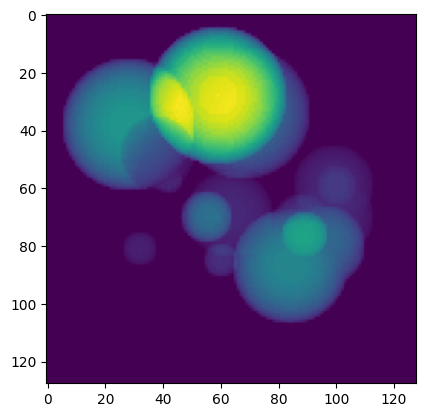

In [8]:
# Custom transform by function -> 三維 -> 二維
def sum_width(img):
    return img.sum(1)   # sum(1) 計算第一維度總和

transform_custom = Compose([
    LoadImage(image_only = True),
    EnsureChannelFirst(),
    Lambda(sum_width)
])

img = transform_custom(filenames[0]["img"])
plt.imshow(img[0])

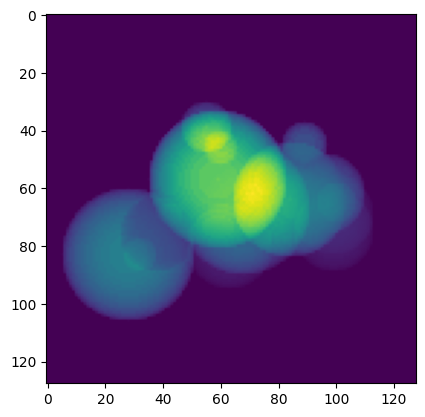

In [9]:
# Custom transform by subclass
class SunDimension(Transform):
    def __init__(self, dim = 1):
        self.dim = dim

    def __call__(self, inputs):
        return inputs.sum(self.dim)

transform_custom2 = Compose([
    LoadImage(image_only = True),
    EnsureChannelFirst(),
    SunDimension(2)
])

img = transform_custom2(filenames[0]["img"])
plt.imshow(img[0])

/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


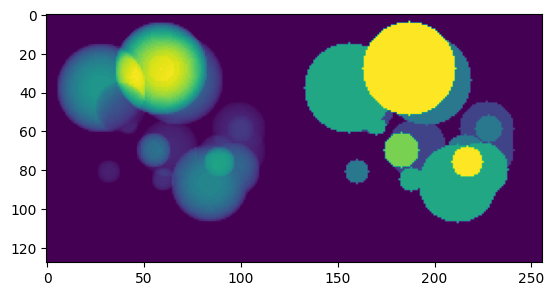

In [10]:
# Custom transform Lambdad
def sum_width(img):
    return img.sum(1)

def max_width(img):
    return img.max(1)

transform_custom3 = Compose([
    LoadImaged(fn_keys),
    EnsureChannelFirstd(fn_keys),
    Lambdad(("img"), sum_width),
    Lambdad(("seg"), max_width)
])

imgd = transform_custom3(filenames[0])
img = imgd["img"]
seg = imgd["seg"]

plt.imshow(np.hstack((img[0] * 5 / img.max(), np.squeeze(seg[0]))))

Dataset

In [11]:
images = [fn["img"] for fn in filenames]

transform_for_dataset = Compose([
    LoadImage(image_only = True),
    EnsureChannelFirst()
])

dataset = Dataset(images, transform_for_dataset)
first_tensor_in_dataset = dataset[0]

print(first_tensor_in_dataset.shape)

torch.Size([1, 128, 128, 128])


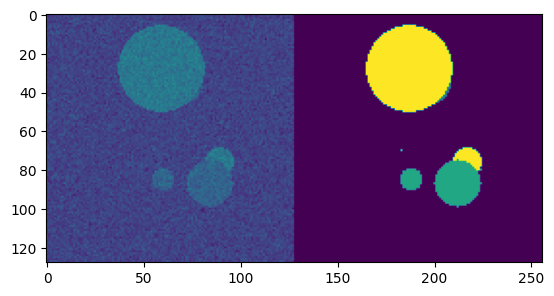

In [12]:
# Array_dataset -> two transform
images = [fn["img"] for fn in filenames]
segs = [fn["seg"] for fn in filenames]

img_transform = Compose([
    LoadImage(image_only = True),
    EnsureChannelFirst(),
    RandSpatialCrop((128, 128, 128), random_size = False),
    RandGaussianNoise(.5, 1, 1)
])
seg_transform = Compose([
    LoadImage(image_only = True),
    EnsureChannelFirst(),
    RandSpatialCrop((128, 128, 128), random_size = False)
])

dataset = ArrayDataset(images, img_transform,
                       segs, seg_transform)
img, seg = dataset[0]

plt.imshow(np.hstack([
    img.numpy()[0,48], seg.numpy()[0, 48]
]))

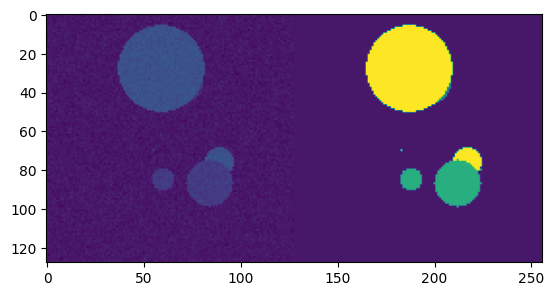

In [13]:
# dict -> 針對指定部分 transform
dict_transform = Compose([
    LoadImaged(fn_keys, image_only = False),
    EnsureChannelFirstd(fn_keys),
    RandGaussianNoised(("img"), (0.9)),
    RandSpatialCropd(fn_keys, (128, 128, 128), random_size = False)
])

dataset = Dataset(filenames, dict_transform)
item = dataset[0]
img, seg = item["img"], item["seg"]

plt.imshow(np.hstack([
    img.numpy()[0, 48], seg.numpy()[0, 48]
]))

Dataloader

['img', 'seg', 'img_meta_dict', 'seg_meta_dict'] torch.Size([5, 1, 128, 128, 128])


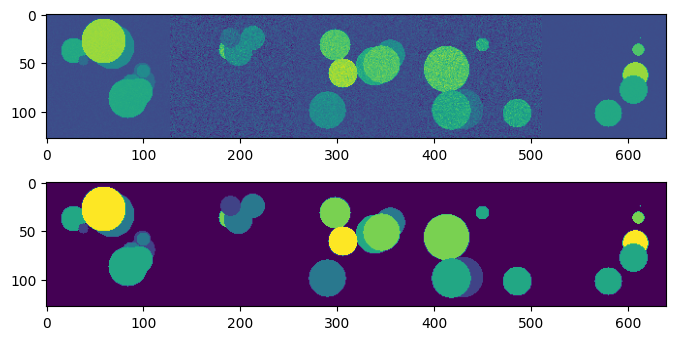

In [14]:
loader = DataLoader(dataset, batch_size = 5, num_workers = 2)
batch = first(loader)
print(list(batch.keys()), batch["img"].shape)

f, ax = plt.subplots(2, 1, figsize = (8, 4))
ax[0].imshow(np.hstack(batch["img"][:, 0, 64]))
ax[1].imshow(np.hstack(batch["seg"][:, 0, 64]))

Dataset caching

In [15]:
# deterministic transform will be saved and will only run first time

Layers

In [16]:
from monai.networks.layers import Conv, Act, split_args, Pool

In [17]:
print(Conv[Conv.CONV, 2](in_channels = 3,
                         out_channels = 64,
                         kernel_size = 3,
                         stride = 1,
                         padding = 1))

print(Conv[Conv.CONV, 3](in_channels = 3,
                         out_channels = 64,
                         kernel_size = 3,
                         stride = 1,
                         padding = 1))

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv3d(3, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))


In [18]:
print(Conv[Conv.CONVTRANS, 2](in_channels = 64,
                              out_channels = 3,
                              kernel_size = 3,
                              stride = 1,
                              padding = 1))

print(Conv[Conv.CONVTRANS, 3](in_channels = 64,
                              out_channels = 3,
                              kernel_size = 3,
                              stride = 1,
                              padding = 1))

ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ConvTranspose3d(64, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))


Activation

In [19]:
print(Act[Act.RELU])

<class 'torch.nn.modules.activation.ReLU'>


Network (self structure)

In [20]:
# Class
class MyNetwork(torch.nn.Module):
    def __init__(self, dims = 3, in_channels = 1, out_channels = 8, kernel_size = 3, pool_kernel = 2, act = "relu"):
        super(MyNetwork, self).__init__()
        # Convolution
        self.conv = Conv[Conv.CONV, dims](in_channels, out_channels, kernel_size = kernel_size)

        # Activation
        act_type, act_args = split_args(act)
        self.act = Act[act_type](**act_args)

        # Pooling
        self.pool = Pool[Pool.MAX, dims](pool_kernel)

    def forward(self, x: torch.Tensor):
        x = self.conv(x)
        x = self.act(x)
        x = self.pool(x)

        return x

In [21]:
# Build default network
default_net = MyNetwork()
print(f"Default structure: {default_net}")
print(f"Output shape: {default_net(torch.ones(2, 1, 20, 20, 30)).shape}")
print(f"\n{'='*25}\n")

# 2D network
elu_2D_net = MyNetwork(dims = 2, in_channels = 3, act=("elu", {"inplace":True}))
print(f"2D_Structure: {elu_2D_net}")
print(f"Output shape: {elu_2D_net(torch.ones(3, 3, 24, 24)).shape}")
print(f"\n{'='*25}\n")

# 3D network
sigmoid_3D_net = MyNetwork(dims = 3, in_channels = 3, act = "sigmoid")
print(f"3D_Structure: {sigmoid_3D_net}")
print(f"Output shape: {sigmoid_3D_net(torch.ones(3, 3, 24, 24, 24)).shape}")

Default structure: MyNetwork(
  (conv): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (act): ReLU()
  (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Output shape: torch.Size([2, 8, 9, 9, 14])


2D_Structure: MyNetwork(
  (conv): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (act): ELU(alpha=1.0, inplace=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Output shape: torch.Size([3, 8, 11, 11])


3D_Structure: MyNetwork(
  (conv): Conv3d(3, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (act): Sigmoid()
  (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Output shape: torch.Size([3, 8, 11, 11, 11])


Network (UNet)

In [22]:
net = monai.networks.nets.UNet(
    spatial_dims = 2,           # 2D or 3D
    in_channels = 3,
    out_channels = 3,
    channels = [8, 16, 32],     # channel counts for layers
    strides = [1, 1]            # stride for mid layers
)
summary(net,
        input_size = (32, 3, 256, 256),
        col_names = ["output_size"],
        col_width = 15)

Layer (type:depth-idx)                                  Output Shape
UNet                                                    [32, 3, 256, 256]
├─Sequential: 1-1                                       [32, 3, 256, 256]
│    └─Convolution: 2-1                                 [32, 8, 256, 256]
│    │    └─Conv2d: 3-1                                 [32, 8, 256, 256]
│    │    └─ADN: 3-2                                    [32, 8, 256, 256]
│    └─SkipConnection: 2-2                              [32, 16, 256, 256]
│    │    └─Sequential: 3-3                             [32, 8, 256, 256]
│    └─Convolution: 2-3                                 [32, 3, 256, 256]
│    │    └─ConvTranspose2d: 3-4                        [32, 3, 256, 256]
Total params: 9,935
Trainable params: 9,935
Non-trainable params: 0
Total mult-adds (G): 20.83
Input size (MB): 25.17
Forward/backward pass size (MB): 2197.82
Params size (MB): 0.04
Estimated Total Size (MB): 2223.02

# **== Core end-to-end workflow==**
* Dataset
* Transform
* Training loop
* Model evaluation
* Ignite-based workflow

Youtube: https://www.youtube.com/watch?v=-wRHIxBrWVc  
Git: https://github.com/Project-MONAI/monai-bootcamp/blob/main/MONAICore/MONAI%20End-to-End%20Workflow%20-%20Solution.ipynb

Dataset

In [23]:
# Setup data directory
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory

print(root_dir)

/tmp/tmpjog3wsxv


In [ ]:
# Download MedNIST
resource = "https://www.dropbox.com/s/5wwskxctvcxiuea/MedNIST.tar.gz?dl=1"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

compredded_file = os.path.join(root_dir, "MedNIST.tar.gz")
data_dir = os.path.join(root_dir, "MedNIST")

if not os.path.exists(data_dir):
    download_and_extract(resource, compredded_file, root_dir, md5)

In [25]:
# random seed
set_determinism(seed = 42)
rseed = 4242

In [26]:
# Random check images in dataset
subdirs = sorted(filter(os.path.isdir, glob(f"{data_dir}/*")))
class_names = list(map(os.path.basename, subdirs))
num_class = len(class_names)

image_files = [sorted(glob(f"{f}/*")) for f in subdirs]

num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = sum(image_files, [])
image_class_list = sum([[i] * n for i, n in enumerate(num_each)], [])

num_total = len(image_class_list)
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}\n"
      f"Image dimensions: {image_width} * {image_height}\n"
      f"Label names: {class_names}\n"
      f"Label counts: {num_each}")

Total image count: 58954
Image dimensions: 64 * 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


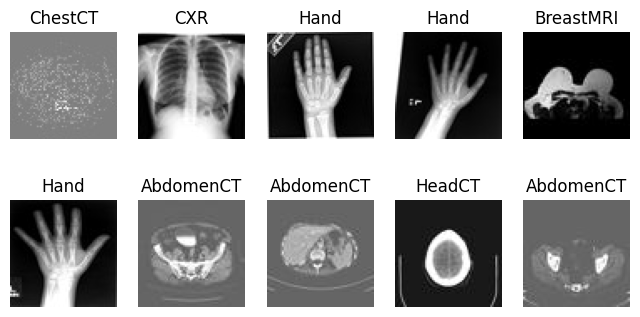

In [28]:
# Plot images
plt.subplots(2, 5, figsize=(8,4))
for i, k in enumerate(np.random.randint(num_total, size = 10)):
    im = PIL.Image.open(image_files_list[k])
    plt.subplot(2, 5, i+1)
    plt.axis("off")
    plt.title(class_names[image_class_list[k]])
    plt.imshow(np.array(im), cmap="gray", vmin=0, vmax=255)

In [29]:
parts = partition_dataset_classes(data = np.arange(len(image_files_list)),  # 索引列表
                                  classes = image_class_list,   # image's label in list
                                  ratios = [0.8, 0.1, 0.1],
                                  shuffle = True,
                                  drop_last = True,
                                  seed = rseed)

# 創造三個空list
image_sets = [list(), list(), list()]
label_sets = [list(), list(), list()]

# 依 idx 依序將image, label 增加到list 中
for i, part in enumerate(parts):
    image_sets[i] = [image_files_list[idx] for idx in part]
    label_sets[i] = [image_class_list[idx] for idx in part]

train_x, val_x, test_x = image_sets
train_y, val_y, test_y = label_sets

print(f"Training count: {len(train_x)}, Validation count: {len(val_x)}, Test count: {len(test_x)}")

Training count: 47163, Validation count: 5895, Test count: 5895


Transform

In [30]:
rseed = 4242

# Transform
train_transform = Compose([
    LoadImage(image_only = True),
    EnsureChannelFirst(),
    ScaleIntensity(),
    RandRotate(prob = 0.5, range_x = 15).set_random_state(rseed),
    RandFlip(prob = 0.5, spatial_axis = 0).set_random_state(rseed),
    RandZoom(prob = 0.5, min_zoom = 0.9, max_zoom = 1.2).set_random_state(rseed)
    ])

val_transform = Compose([
    LoadImage(image_only = True),
    EnsureChannelFirst(),
    ScaleIntensity()
    ])

# activation
act = Compose([Activations(softmax = True)])

# One-hot encoding
to_onehot = Compose([AsDiscrete(to_one_hot = num_class)])

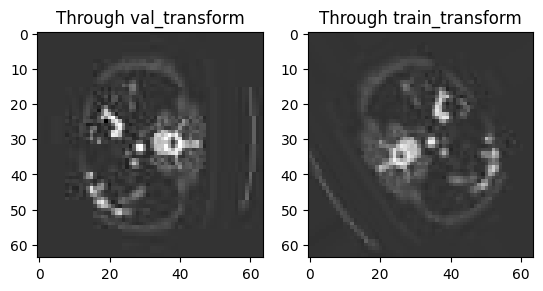

In [31]:
# Test transform
image_index = 50
# Through transform
val_output = val_transform(image_files_list[image_index])
train_output = train_transform(image_files_list[image_index])

# Plot images
plt.subplot(1, 2, 1)
plt.imshow(np.array(val_output[0]), cmap = "gray", vmin=0, vmax=1)      # 顏色數值的上下限: 0 ~ 1
plt.title("Through val_transform")

plt.subplot(1, 2, 2)
plt.imshow(np.array(train_output[0]), cmap = "gray", vmin=0, vmax=1)
plt.title("Through train_transform");


Dataset

In [32]:
# Define dataset, groups : image, label, transform
class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transform):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transform(self.image_files[index]), self.labels[index]

# Dataset
train_dataset = MedNISTDataset(train_x, train_y, train_transform)
val_dataset = MedNISTDataset(val_x, val_y, val_transform)
test_dataset = MedNISTDataset(test_x, test_y, val_transform)

Dataloader

In [33]:
# Dataloader
BATCH_SIZE = 512

train_dataloader = DataLoader(dataset = train_dataset,
                              batch_size = BATCH_SIZE,
                              shuffle = True)

val_dataloader = DataLoader(dataset = val_dataset,
                            batch_size = BATCH_SIZE)

test_dataloader = DataLoader(dataset = test_dataset,
                             batch_size = BATCH_SIZE)

Model

In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model_MedNist = DenseNet121(spatial_dims = 2,
                            in_channels = 1,
                            out_channels = num_class,
                            pretrained = True).to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_MedNist.parameters(),
                             lr = 0.0001)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 75.4MB/s]


Network training

In [ ]:
epoch_num = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
auc_metric = ROCAUCMetric()

for epoch in range(epoch_num):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")

    epoch_loss = 0
    step = 1

    steps_per_epoch = len(train_dataset) // train_dataloader.batch_size

    # put the network in train mode; this tells the network and its modules to
    # enable training elements such as normalisation and dropout, where applicable
    net.train()
    for batch_data in train_dataloader:

        # move the data to the GPU
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)

        # prepare the gradients for this step's back propagation
        optimizer.zero_grad()

        # run the network forwards
        outputs = model_MedNist(inputs)

        # run the loss function on the outputs
        loss = loss_fn(outputs, labels)

        # compute the gradients
        loss.backward()

        # tell the optimizer to update the weights according to the gradients
        # and its internal optimisation strategy
        optimizer.step()

        epoch_loss += loss.item()
        print(f"{step}/{len(train_dataset) // train_dataloader.batch_size + 1}, training_loss: {loss.item():.4f}")
        step += 1

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    # after each epoch, run our metrics to evaluate it, and, if they are an improvement,
    # save the model out

    # switch off training features of the network for this pass
    model_MedNist.eval()

    # 'with torch.no_grad()' switches off gradient calculation for the scope of its context
    with torch.no_grad():
        # create lists to which we will concatenate the the validation results
        preds = list()
        labels = list()

        # iterate over each batch of images and run them through the network in evaluation mode
        for val_data in val_dataloader:
            val_images, val_labels = val_data[0].to(device), val_data[1].to(device)

            # run the network
            val_pred = model_MedNist(val_images)

            preds.append(val_pred)
            labels.append(val_labels)

        # concatenate the predicted labels with each other and the actual labels with each other
        y_pred = torch.cat(preds)
        y = torch.cat(labels)

        # we are using the area under the receiver operating characteristic (ROC) curve to determine
        # whether this epoch has improved the best performance of the network so far, in which case
        # we save the network in this state
        y_onehot = [to_onehot(i) for i in decollate_batch(y, detach=False)]
        y_pred_act = [act(i) for i in decollate_batch(y_pred)]

        auc_metric(y_pred_act, y_onehot)
        auc_value = auc_metric.aggregate()
        auc_metric.reset()
        metric_values.append(auc_value)

        acc_value = torch.eq(y_pred.argmax(dim=1), y)
        acc_metric = acc_value.sum().item() / len(acc_value)

        if auc_value > best_metric:
            best_metric = auc_value
            best_metric_epoch = epoch + 1
            torch.save(net.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
            print("saved new best metric network")

        print(
            f"current epoch: {epoch + 1} current AUC: {auc_value:.4f} /"
            f" current accuracy: {acc_metric:.4f} best AUC: {best_metric:.4f} /"
            f" at epoch: {best_metric_epoch}"
        )

print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

Plot loss and metric

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [(i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

Eval model

In [ ]:
model_MedNist.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model_MedNist.eval()

y_true = []
y_pred = []

with torch.inference_mode():
    for test_data in test_dataloader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)

        pred = model_MedNist(test_images).argmax(dim = 1)

        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

Classification report

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names = class_names))

Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix

cmat = confusion_matrix(y_true, y_pred)

cax = plt.matshow(cmat, cmap="RdBu", interpolation="nearest")
plt.colorbar(cax)

cax.axes.set_xticks(list(range(len(class_names))), class_names, rotation=270)
cax.axes.set_yticks(list(range(len(class_names))), class_names)

plt.show()